# Create a Script from a Jupyter Notebook
Sometime it is useful to transform your notebook in an actual script e.g.:

- if you want it to be executed automatically (unattended)
- if you want to create a module out of it in order to use it in a bigger application 

## extract code from Jupyter
Jupyter has a very wide range of formats to export the content of a notebook; some of them are a graphical export (e.g. html or pdf -- this requires a latex installation) or textual export (ascii, rtf), etc. 

To start creating a python script from your notebook, open it into Jupyter, then
1. from the File menu select `save and export notebook as`
2. from the submenu select `Executable script`
this will save a file in your Download directory named with the title of your notebook, but with .py extension

You can now open this file with your favorite code editor; here is what you will see:

- before every cell there will be a comment with the cell execution number
- every code cell will be copied in an individual block of commands
- markdown cells and raw cells will be presented as comments
- output will be removed

In the following sections I will list some cleanup actions which will help you transform this script into a more manageable piece of code

## manage magic code
magic code is translated into the equivalent python call e.g.

```
?sum
```

becomes

```python
get_ipython().run_line_magic('pinfo', 'sum')
```

most of the time you may want to get rid of all of this kind of code as some functionalities (e.g. accessing documentation) are intended only for interactive usage within a jupyter notebook.

Other functionalities (e.g. timing your cell execution) may be better managed with other libraries.

## add code to save tables
Jupyter conveniently shows pandas `DataFrame`s as tables; you may want to extract these results into files.

To access these tables from a script you can save them into files

### small size
If your table are small you may be willing to save them in some simple format:
- csv using
  ```python
  df.to_csv("my_file.csv")
  ```
- [Microsoft Excel](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_excel.html) using `openpyxl` [optional library](https://openpyxl.readthedocs.io/en/stable/tutorial.html) 
  ```python
  df.to_excel("my_file.xlsx")
  ```

### large size
For larger tables or more complex tasks binary formats may help.
- [Apache Parquet](https://parquet.apache.org/) is a columnar binary format ideal for large data collections and high performance computation; it requires some optional library e.g. [pyarrow](https://arrow.apache.org/docs/python/index.html) see [documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_parquet.html)
  ```python
  df.to_parquet("my_file.pqt")
  ```
- [hdf5](https://www.hdfgroup.org/solutions/hdf5/) is a binary format which can contain multiple tables in a single file (see [documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_hdf.html) )
    ```python
  df.to_hdf("my_file.pqt")
  ```

### databases
Pandas has a simple mapping [from tables to data frames](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_sql.html) which requires [sqlalchemy](https://docs.sqlalchemy.org/en/20/) and a driver of the database. Python basic distribution include [sqlite](https://docs.python.org/3/library/sqlite3.html) but many more are available as optional packages
  ```python
  df.to_sql(name='my_table', con=engine)
  ```

## add code to save figures
the following example works for `matplotlib` and any library based on it, like `seaborn`.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
california = pd.read_csv("california_pb_2023.csv")

The simplest way to save an image is to 
1. store the `Axis` object created into some variable
2. reach the `Figure` object from the `.figure` attribute
3. use the `.savefig()` [method](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html)

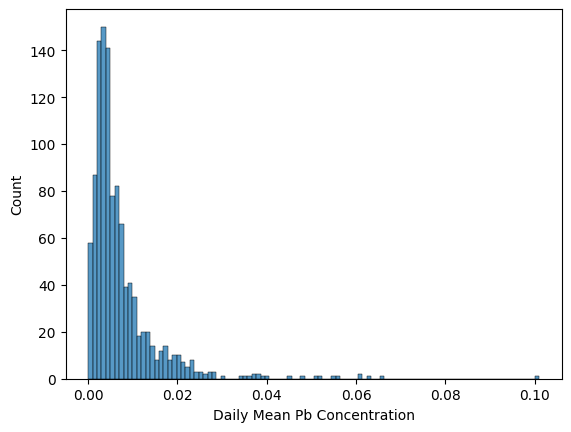

In [4]:
ax = sns.histplot(california,x="Daily Mean Pb Concentration")
ax.figure.savefig("pb_2003.png")

A more complex sequence is required when working with [multiple plots](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html) either stacked or overlapped.

In this case the `pd.subplot()` function creates multiple charts (axis) in a single figure

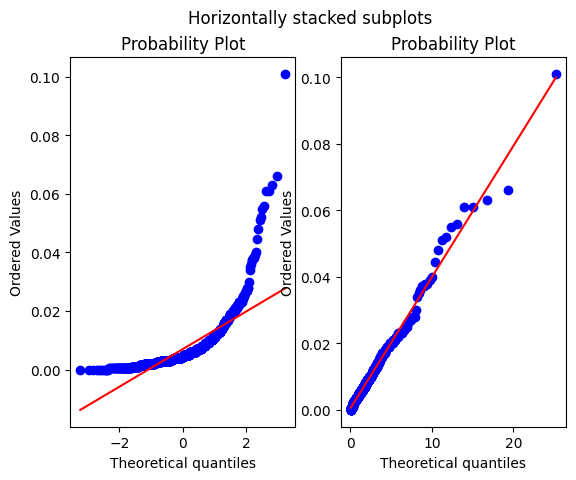

In [10]:
# this code is general: two charts in a single row
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Horizontally stacked subplots')

# this code is specific for this function
from scipy import stats
stats.probplot(california["Daily Mean Pb Concentration"], plot=ax1)
stats.probplot(california["Daily Mean Pb Concentration"], plot=ax2,dist=stats.distributions.lognorm(s=1))

fig.savefig("probplots.png")

## clean up the code
The following suggestions holds for any python script and are not strictly required for the execution.

- move all `import` statements at the beginning of the file
- organize the code in functions and classes; possibly add type annotations
- create a single entry point at the bottom of the code with the usual
  ```python
  if __name__ == "__main__":
      main()
    ```
- add command line options management using libraries like `optparse` [(see here)](https://docs.python.org/3/library/optparse.html)
- separate data and configuration from code: libraries like `toml` [(see here)](https://github.com/uiri/toml) can help reading configuration files 
- transform absolute paths into relative paths
- consider using pyproject.html to [collect dependencies and constraints](https://packaging.python.org/en/latest/guides/writing-pyproject-toml/)
- consider using a linter (e.g. [pylint](https://www.pylint.org/) or [ruff](https://docs.astral.sh/ruff/)) to evaluate code inconsistencies
- create unit tests to verify your functions individually; `pytest` helps in this [task](https://docs.pytest.org/en/stable/)
- add documentation per each function or class as well as a module doc string
- use a code formatter to keep your style consistent (e.g. black

## add shell script to launch the code
I find it very convenient to have a shell script taking care of
- setting up the working directory of the process properly
- activate any virtual environment as needed
- fix the environment variables

e.g.
```bash
#!/bin/bash

# change the process directory to this one
cd $(dirname $0)

# activate a local virtual environment
source .venv/bin/activate

# set up some environment variables
export PYTHONPATH=$(pwd)

# launch the application
# forwards all command line arguments
python -m myapp $@
```